In [1]:
%load_ext blackcellmagic

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import os
import pathlib
from tqdm import tqdm_notebook as tqdm
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import RunningAverage
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import ModelCheckpoint
from sklearn.model_selection import train_test_split 
from ignite.metrics import Loss
from functools import partial
from collections import defaultdict
from model import UNet

In [3]:
torch.__version__, np.__version__

('1.3.1', '1.16.3')

For training versions: ('1.3.1', '1.16.3') was used

In [4]:
config = {
    "data_path": "./data/train_size_1024_768",
    "device": "cuda",
    "test_size": 0.1,
    "random_seed": 42,
    "resize": (512, 384),
    "batch_size": 4,
    "learning_rate": 0.0001
}

In [5]:
labels_folder = pathlib.Path(config["data_path"]).resolve() / "labels"
all_names = [x.name for x in labels_folder.iterdir() if x.is_file()]
train_idx, test_idx = train_test_split(
    np.arange(len(all_names)),
    test_size=config["test_size"],
    random_state=config["random_seed"],
    shuffle=True,
)
train_names = [x for i, x in enumerate(all_names) if i in train_idx]
test_names = [x for i, x in enumerate(all_names) if i in test_idx]

In [6]:
def load_input_image(path, out_size, mean):
    input_image = Image.open(path).resize(out_size, Image.LANCZOS)
    input_array = np.array(input_image, dtype=np.float32)
    return input_image, ((torch.from_numpy(input_array) - mean) / 255.0).permute(2, 0, 1)


def load_label_image(path, out_size):
    label_image = Image.open(path).resize(out_size, Image.NEAREST)
    label_array = np.array(label_image)[:, :, 0]
    label_array[(label_array <= 128) & (label_array > 0)] = 1
    label_array[label_array > 128] = 2
    return label_image, torch.LongTensor(label_array)


class SegmentationDataset(Dataset):
    def __init__(
        self,
        data_path,
        file_names,
        dataset_mean=(69.2614, 55.9220, 32.6043),
        out_size=(512, 384),
        load_augumentations=True,
    ):
        images_folder = pathlib.Path(data_path).resolve() / "images"
        labels_folder = pathlib.Path(data_path).resolve() / "labels"
        all_names = file_names
        self.all_pairs = [(images_folder / name, labels_folder / name) for name in all_names]
        self.out_size = out_size
        self.mean = torch.tensor(dataset_mean)
        self.all_data = []
        self.all_images = []
        for input_path, label_path in tqdm(self.all_pairs, desc="Loading images to RAM"):
            input_image, input_normalized = load_input_image(input_path, self.out_size, self.mean)
            label_image, label_long = load_label_image(label_path, self.out_size)
            self.all_data.append((input_normalized, label_long))
            self.all_images.append((input_image, label_image))
        if load_augumentations:
            augumented_folder = images_folder / "output"
            all_augumented_files = list(augumented_folder.iterdir())
            for name in tqdm(all_names, desc="Loading augumentations to RAM"):
                input_paths = [
                    x
                    for x in all_augumented_files
                    if f"_{name}_" in x.name and not x.name.startswith("_groundtruth")
                ]
                label_paths = [
                    x
                    for x in all_augumented_files
                    if f"_{name}_" in x.name and x.name.startswith("_groundtruth")
                ]
                pairs = defaultdict(list)
                for input_path in input_paths:
                    pairs[input_path.name.split("_")[3]].append(input_path)
                for label_path in label_paths:
                    pairs[label_path.name.split("_")[5]].append(label_path)
                for input_path, label_path in list(pairs.values()):
                    input_image, input_normalized = load_input_image(input_path, self.out_size, self.mean)
                    label_image, label_long = load_label_image(label_path, self.out_size)
                    self.all_data.append((input_normalized, label_long))
                    self.all_images.append((input_image, label_image))

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        return self.all_data[idx]

    def get_image(self, idx):
        return self.all_images[idx]

In [ ]:
train_dataset = SegmentationDataset(config["data_path"], train_names, out_size=config["resize"])

In [7]:
test_dataset = SegmentationDataset(
    config["data_path"], test_names, out_size=config["resize"], load_augumentations=False
)

### Training

In [8]:
model = UNet(3,3)
model_path = "./models/unet_W512_H384_1_cel=0.291518.pth"
model.load_state_dict(torch.load(model_path))
model.to(config["device"])

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
def improvement_function(testing_evaluator, test_data_loader, trainer):
    testing_evaluator.run(test_data_loader)
    metrics = testing_evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg loss: {:.3f}".format(trainer.state.epoch, metrics["cel"]))

    return -metrics["cel"]


train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])
loss = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model, optimizer, loss, device=config["device"])
evaluator = create_supervised_evaluator(model, metrics={"cel": Loss(loss)}, device=config["device"])

checkpoint = ModelCheckpoint(
    "./models",
    f"unet",
    score_name="cel",
    score_function=partial(improvement_function, evaluator, test_data_loader),
    n_saved=2,
    create_dir=True,
    require_empty=False,
)

trainer.add_event_handler(
    Events.EPOCH_COMPLETED, checkpoint, {f"W{config['resize'][0]}_H{config['resize'][1]}": model}
)

RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

pbar = ProgressBar(persist=True)
pbar.attach(trainer, ["loss"])

state = trainer.run(train_data_loader, max_epochs=1)

In [9]:
model.train()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
def spot_check_model(model, dataset, idx, config):
    result = model.forward(dataset[idx][0].unsqueeze(0).to(config["device"]))
    probab = nn.Softmax(dim=0).forward(result[0])
    result_cuda = probab.argmax(dim=0)
    numpy_result = result_cuda.cpu().numpy()
    numpy_result[numpy_result == 1] = 128
    numpy_result[numpy_result == 2] = 255
    return Image.fromarray(numpy_result.astype("uint8"), mode="L"), dataset.get_image(idx)[1]

In [ ]:
pred, true = spot_check_model(model, test_dataset, 0, config)

In [10]:
%%time
test_bayesian = []
with torch.no_grad():
    input_image = test_dataset[0][0].unsqueeze(0).to(config["device"])
    for i in range(100):
        result = model.forward(input_image)
        probab = nn.Softmax(dim=0).forward(result[0])
        test_bayesian.append(probab.cpu().numpy())

CPU times: user 13.6 s, sys: 6.19 s, total: 19.8 s
Wall time: 19.8 s


In [11]:
final_bayesian = np.array(test_bayesian)

In [12]:
mean = final_bayesian.mean(axis=0)

In [13]:
std = final_bayesian.std(axis=0)

In [39]:
def postprocess_model(result, islet_threshold, exo_threshold):
    classes = result.argmax(axis=0).astype("uint8")
    final = np.zeros_like(classes)
    sure_islets = result[2, :, :] > islet_threshold
    final[(classes == 2) & sure_islets] = 255
    final[(classes == 2) & ~sure_islets] = 128
    sure_exo = result[1, :, :] > exo_threshold
    final[(classes == 1) & sure_exo] = 128
    return final

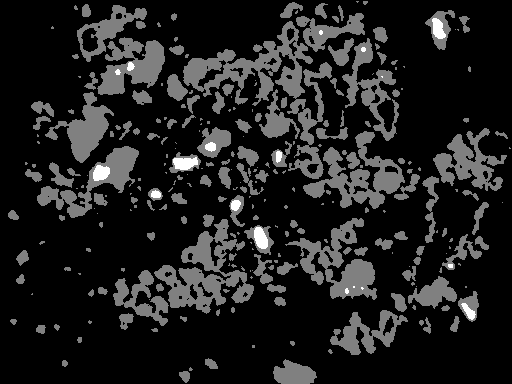

In [51]:
Image.fromarray(postprocess_model(mean, 0.9, 0.2), mode="L")

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [34]:
sure_islets

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
mean_argmax = mean.argmax(axis=0)
mean_argmax[mean_argmax == 1] = 0
mean_argmax[mean_argmax == 2] = 255
mean_argmax = mean_argmax.astype("uint8")
islets_image = Image.fromarray(mean_argmax, mode="L")

In [ ]:
amplify = 1 / std[2, :, :].max()

In [ ]:
amplified = std[2, :, :] * amplify

In [ ]:
amp_bin = (amplified * 255).astype("uint8")

In [ ]:
amp_bin[amp_bin < 0] = 0
uncertainity = Image.fromarray(
    np.array([255 - amp_bin, 255 - amp_bin, 255 - amp_bin, np.ones_like(amp_bin) * 255])
    .astype("uint8")
    .transpose([1, 2, 0]),
    mode="RGBA",
)

In [ ]:
uncertainity_array = (
    np.array([255 - amp_bin, 255 - amp_bin, 255 - amp_bin, np.ones_like(amp_bin) * 255])
    .astype("uint8")
    .transpose([1, 2, 0])
)

In [ ]:
uncertainity_array[mean_argmax == 0] = [0,0,0,255]

In [ ]:
Image.fromarray(uncertainity_array, mode="RGBA")

In [ ]:
all_classes = test_dataset[0][1].numpy().astype("uint8")
all_classes[all_classes == 1] = 0
all_classes[all_classes == 2] = 255
Image.fromarray(all_classes, mode="L")

In [ ]:
mean_argmax == 255

In [ ]:
amp_image = Image.fromarray((amplified * 255).astype("uint8"), mode="L")

In [ ]:
converted_islets = islets_image.convert("RGBA")

In [ ]:
uncertainity

In [ ]:
converted_islets.

In [ ]:
Image.blend(converted_islets, uncertainity, alpha=0.3)

In [ ]:
true

In [ ]:
pred

In [ ]:
pred